In [ ]:

!wget --no-check-certificate \
    https://namespace.co.ke/ml/dataset.zip \
    -O /content/catsdogs.zip

--2021-06-02 09:44:53--  https://namespace.co.ke/ml/dataset.zip
Resolving namespace.co.ke (namespace.co.ke)... 109.106.250.14
Connecting to namespace.co.ke (namespace.co.ke)|109.106.250.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228894139 (218M) [application/zip]
Saving to: ‘/content/catsdogs.zip’

/content/catsdogs.z 100%[===================>] 218.29M  14.8MB/s    in 15s     

2021-06-02 09:45:09 (14.2 MB/s) - ‘/content/catsdogs.zip’ saved [228894139/228894139]



In [ ]:
import os
import zipfile
with zipfile.ZipFile('catsdogs.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cats_dogs')
base_dir = '/content/cats_dogs/dataset'
train_dir = os.path.join(base_dir, 'training_set')
validation_dir = os.path.join(base_dir, 'test_set')

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
training_set = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=32,
                                             image_size=(150, 150))
val_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=32,
                                                  image_size=(150, 150))

Found 8000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [ ]:
data_augmentation=keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
   keras.layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

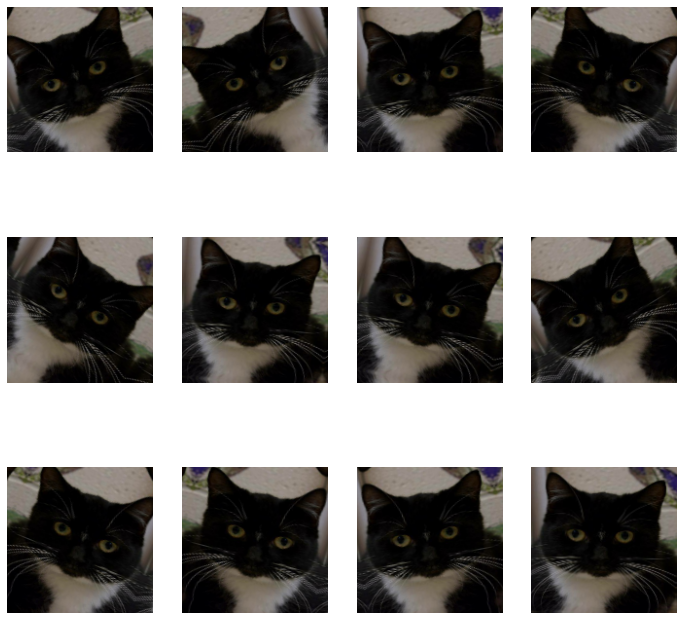

In [ ]:
#applying some tranformations:
import numpy as np
import matplotlib.pyplot as plt
for images, labels in training_set.take(1):
    plt.figure(figsize=(12, 12))
    first_image = images[0]
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0)
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [ ]:
base_model = keras.applications.VGG19(
    weights='imagenet',  
    input_shape=(150, 150, 3),
    include_top=False)  

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
inputs = keras.Input(shape=(150, 150, 3))

In [ ]:
x = data_augmentation(inputs) 

In [ ]:
from tensorflow import keras
from keras.applications.vgg19 import preprocess_input, decode_predictions
x=preprocess_input(x)



In [ ]:
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  

outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy',metrics=keras.metrics.BinaryAccuracy())
model.fit(training_set, epochs=10, validation_data=val_dataset)

Epoch 1/10
250/250 [==============================] - 63s 249ms/step - loss: 7.6308 - binary_accuracy: 0.4994 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 2/10
250/250 [==============================] - 62s 247ms/step - loss: 7.6253 - binary_accuracy: 0.4996 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 3/10
250/250 [==============================] - 62s 247ms/step - loss: 7.6266 - binary_accuracy: 0.4999 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 4/10
250/250 [==============================] - 62s 246ms/step - loss: 7.6247 - binary_accuracy: 0.5000 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 5/10
250/250 [==============================] - 62s 246ms/step - loss: 7.6227 - binary_accuracy: 0.5001 - val_loss: 7.6246 - val_binary_accuracy: 0.5000
Epoch 6/10
250/250 [==============================] - 62s 246ms/step - loss: 5.5760 - binary_accuracy: 0.6317 - val_loss: 2.1078 - val_binary_accuracy: 0.8600
Epoch 7/10
250/250 [==========================

In [ ]:
!wget https://freepngdownload.com/image/cute-kitten-png.png -o demo.png

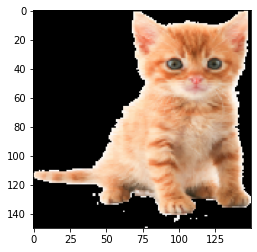

In [ ]:
import matplotlib.pyplot as plt
from keras.preprocessing import image

x = image.load_img('/content/cute-kitten-png.png',target_size=(150, 150, 3))
plt.imshow(x)

In [ ]:
x=image.img_to_array(x)
x.shape

(150, 150, 3)

In [ ]:
x = x.reshape(1,150,150,3)
x = preprocess_input(x)
x.shape

(1, 150, 150, 3)

In [ ]:
from keras.applications.vgg19 import preprocess_input,decode_predictions
import numpy as np
y =model.predict(x)

class_names = ['cat', 'dog']
max_proba = np.argmax(y, axis=-1)[0]
print(max_proba, y)
predicted_class = class_names[max_proba]
predicted_class


0 [[3.8448117]]


'cat'

In [ ]:

model.save('major.hdf5')


In [ ]:
!pip install streamlit --quiet
!pip install pyngrok==4.1.1 --quiet
from pyngrok import ngrok

In [ ]:
%%writefile app.py
import streamlit as st
from tensorflow import keras
from keras.applications import vgg19
from keras.applications.vgg19 import preprocess_input,decode_predictions
from PIL import Image
import cv2
import numpy as np

@st.cache()
def load_model():
  model = keras.models.load_model('/content/major.hdf5')
  return model

st.title("Cat Vs Dog")
upload = st.file_uploader(label="Upload the Image")
if upload is not None:
  file_bytes = np.asarray(bytearray(upload.read()), dtype=np.uint8)
  opencv_image = cv2.imdecode(file_bytes, 1)
  st.image(upload,width=300)
  model = load_model()
  if st.button('PREDICT'):
    x = cv2.resize(opencv_image,(150,150))
    x = x.reshape(1,150,150,3)
    x = preprocess_input(x)
    y =model.predict(x)
    class_name=['CAT','DOG']
    max_proba=np.argmax(y)
    predicted_classes=class_name[max_proba]  
    label = predicted_classes
    st.title(f'{label}') 
    

Overwriting app.py


In [ ]:
!nohup streamlit run app.py &
url = ngrok.connect(port='8501')
url

nohup: appending output to 'nohup.out'


'http://0e488016b669.ngrok.io'